In [1]:
import csv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm_notebook as tqdm
import random

from skimage.transform import resize 
from skimage.io import imread
from sklearn.metrics import accuracy_score

import keras
import tensorflow
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet_v2 import preprocess_input as pi_rnv2
from tensorflow.keras.applications.vgg19 import preprocess_input as pi_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as pi_mobv2
from tensorflow.keras.applications.xception import preprocess_input as pi_xcep

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks

from keras.models import load_model
import keras.utils as image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoostClassifier, Pool, sum_models
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

%matplotlib inline
sns.set()

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
#!pip install xgboost --upgrade
xgb.__version__

'2.0.3'

# ResNet152V2 + XGBoost + GlobalAveragePooling2D

In [3]:
%%time
#Валидация

model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0) #отключаем, так как мы предсказываем ниже массив данных, а не 1 значение
        x = pi_rnv2(x) #/ 255

        data.append(x)
        target_arr.append(i)

print(f'Predict ResNet152V2_GlobalAveragePooling2D')
arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D() #уменьшает размерность глобально
features = avg_pool(arrays)
data_arr = features.numpy()

# data_arr = []

# for arr in features:
#     data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Данные для валидации готовы!')

Обработано: 0it [00:00, ?it/s]

Predict ResNet152V2_GlobalAveragePooling2D
Данные для валидации готовы!
CPU times: total: 14min 2s
Wall time: 8min 59s


In [29]:
Y_val.unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [ ]:
# GlobalAveragePooling2D
# Входной тензор
input_tensor = tensorflow.random.normal(shape = (1, 10, 10, 3))

# Создаем слой GlobalAveragePooling2D
global_avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D()

# Применяем слой к тензору
output_tensor = global_avg_pool(input_tensor)

# Вывод
print(f"Входной тензор: {input_tensor.shape}")
print(f"Выходной тензор: {output_tensor.shape}")

In [ ]:
%%time
#Для предобученной сети
model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

folder_name = [
               'trash',
               'wf', 
               'prefin', 
               #'econ', 
               'stand', 
               #'imp', 
               'plan', 
               'street', 
               'balc', 
               'mop'
              ]

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN_8\train'
val_names = os.listdir(val_path) 

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы в 1 batch
h = 0        #шаг


params = {
         'objective': 'multi:softmax',
         'num_class': len(folder_name),
         'learning_rate': 0.1,
         'max_depth': 5,
         'subsample': 0.8,
         'colsample_bytree': 0.8,
         'seed': 42,
         'eval_metric': 'mlogloss',
         #'updater': 'refresh',
         #'process_type': 'update',
         #'refresh_leaf': True,
         #'reg_lambda': 3,  # L2
         'reg_alpha': 3,  # L1
         'silent': False
        }

# early_stop = xgb.callback.EarlyStopping(rounds = 50, 
#                                         metric_name = 'mlogloss', 
#                                         data_name = 'eval', 
#                                         save_best = True
#                                        )

#ДЛЯ ПРОДОЛЖЕНИЯ обучения необходимо скорректировать j и подгрузить нашу модель catmodel_vgg19.cbm
#модель выше закоментить
xgbc = xgb.XGBClassifier()
xgbc.load_model('xgboost_rn152v2_md5_gap_1.model')

accuracy = []

epochs = 1

for epoch in range(epochs):
    
    print(f'Эпоха № {epoch + 1}')
    
    for j in tqdm(range(0, 70, 1), position = 0):  #28 х 5000 = 140000 и 49 х 3000

        data = []        #input array 
        target_arr = []  #output array 

        for n, name_folder in enumerate(val_names):
            class_path = val_path + '\\' + name_folder  #путь к папке первого класса
            img_names = os.listdir(class_path)          #имена фото в папке

            foto = int(fotos * class_weights[n])        #количесто фото на класс в зависимости от веса (баланса)
            h = foto * j                                #шаг, который контролирует batchs

            #print("\r", end = "") #чистим вывод
            #print(f'j = {j}, h = {h}, n = {n}')        #принтим шаги j и h

            #for img_name in tqdm(img_names, 'Обработанно файлов', position = 0):
            for i in range(0, foto, 1):
            #for i in tqdm(range(0, foto, 1), position = 1): #<---
                img = keras.utils.load_img(class_path + '\\' + img_names[i + h], target_size = (224, 224))
                x = keras.utils.img_to_array(img)
                #x = np.expand_dims(x, axis = 0) #отключил, чтобы не добавлять размерность и полностью передать data_arr в VGG19 для прогноза
                x = pi_rnv2(x) #/ 255  #в некоторых случаях необходимо делить на 255, согласно док vgg19 не масштабируется

                data.append(x)
                #data.append(model_vgg_19.predict(x, verbose = None).flatten()) #тут наши факторы вытянутые в массив
                target_arr.append(n)                                            #тут наша метка по классу

        print(f'Обучение модели № {j + 1}')

        arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data

        avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D() #уменьшает размерность глобально
        features = avg_pool(arrays)
        data_arr = features.numpy()

        #data_arr = []

        #for arr in features:
        #    data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays)

        df_1 = pd.DataFrame(target_arr, columns = ['Y'])
        df_2 = pd.DataFrame(data_arr)
        df = pd.concat([df_1, df_2], axis = 1)
        df = df.sample(frac = 1).reset_index(drop = True)          #перемешиваем строки
        Y = df['Y']
        X = df.drop(['Y'], axis = 1)

        train_dmatrix = xgb.DMatrix(data = X, label = Y) 
        test_dmatrix = xgb.DMatrix(data = X_val, label = Y_val)

        eval_data = [(train_dmatrix, 'train'), (test_dmatrix, 'eval')]
        progress = dict()

        #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)

        if j == 0:                                               #если это первый batch, то просто обучаем модель
            xgbc = xgb.train(
                             params = params, 
                             dtrain = train_dmatrix, 
                             num_boost_round = 500,   #количество деревьев
                             evals = eval_data,
                             evals_result = progress,
                             verbose_eval = 0,
                             early_stopping_rounds = 20,
                             #callbacks = [early_stop]
                            )
            
            xgbc.save_model('xgboost_rn152v2_md5_gap_1.model')
            pred_val = xgbc.predict(xgb.DMatrix(X_val))
            acc = accuracy_score(pred_val, Y_val)
            accuracy.append(acc)

        else:
            xgbc = xgb.train(
                             params = params, 
                             dtrain = train_dmatrix, 
                             num_boost_round = 500,   #количество деревьев
                             evals = eval_data,
                             evals_result = progress,
                             verbose_eval = 0,
                             early_stopping_rounds = 20,
                             #callbacks = [early_stop],
                             xgb_model = xgbc #.get_booster()
                            )
            
            xgbc.save_model('xgboost_rn152v2_md5_gap_1.model')
            pred_val = xgbc.predict(xgb.DMatrix(X_val))
            acc = accuracy_score(pred_val, Y_val)
            accuracy.append(acc)

        print(f'Обучение batch № {j + 1} успешно завершено! Accuracy: {acc}')

pred_val = xgbc.predict(xgb.DMatrix(X_val))
acc = accuracy_score(pred_val, Y_val)
print(f'Итоговая Accuracy: {acc}')

In [ ]:
#Строим графикобучения и теста нашей модели
plt.figure(figsize = (14, 10))
plt.rcParams.update({'font.size': 14})
plt.plot(progress['train']['mlogloss'])
plt.plot(progress['eval']['mlogloss'])
plt.ylabel('mlogloss', fontsize = 14)
#plt.ylim([0, 0.5])
plt.xlabel('Round', fontsize = 14)
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [5]:
#Сохраняем в Excel
writer = pd.ExcelWriter('Accuracy_foto.xlsx')
pd.DataFrame(accuracy).to_excel(writer, 'прогноз')
writer.save()

In [50]:
df = pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2/Iter.xlsx', sheet_name = 6)
#df

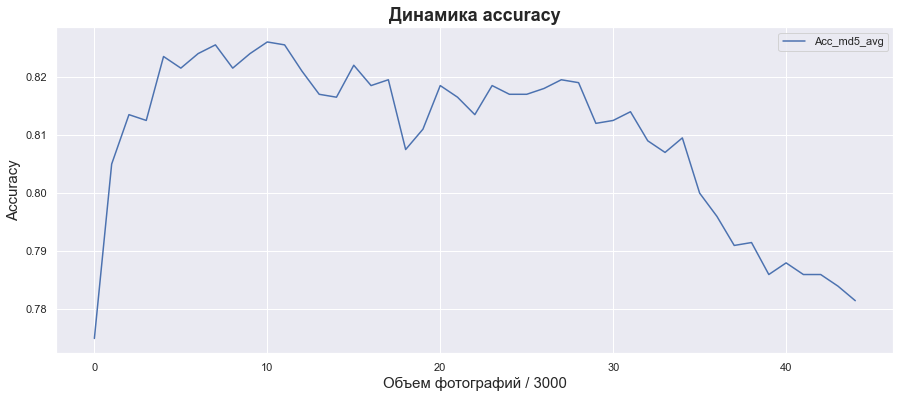

In [51]:
df['Acc_md5_avg'].plot(figsize = (15, 6), label = 'Acc_md5_avg')
#df['Acc_md2'].plot(figsize = (15, 6), label = 'Acc_md2')
#df['D_foto'].plot(figsize = (15, 6))
plt.xlabel('Объем фотографий / 3000', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('Динамика accuracy', fontweight = 'bold', fontsize = 18)
plt.legend()

In [ ]:
%%time
#Валидация

model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

model = xgb.Booster()
model.load_model('xgboost_rn152v2_md5_gap_1.model')

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0) #отключаем, так как мы предсказываем ниже массив данных, а не 1 значение
        x = pi_rnv2(x) #/ 255

        data.append(x)
        target_arr.append(i)

print(f'Predict ResNet152V2_GlobalAveragePooling2D')
arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D() #уменьшает размерность глобально
features = avg_pool(arrays)
data_arr = features.numpy()

# data_arr = []

# for arr in features:
#     data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Predict Model')
preds = model.predict(xgb.DMatrix(X_val))
df['preds'] = preds

print(accuracy_score(preds, Y_val))
CM = confusion_matrix(df['Y_val'], df['preds'])
print(CM)

In [53]:
print(f'Predict Model')
preds = model.predict(xgb.DMatrix(X_val))
df['preds'] = preds

print(accuracy_score(preds, Y_val))
CM = confusion_matrix(df['Y_val'], df['preds'])
print(CM)

Predict Model
0.826
[[108   4   4  16   0   3  15  10]
 [  6 200  41   2   0   0   7   4]
 [  3  14 273  11   0   0   3  16]
 [ 24   1   7 193   2   0   1  32]
 [  4   0   0   0 274   2   0   0]
 [  2   2   0   1   0 251   4   0]
 [ 15  10   6   9   0   4 148   8]
 [ 16   1   8  21   0   2   7 205]]


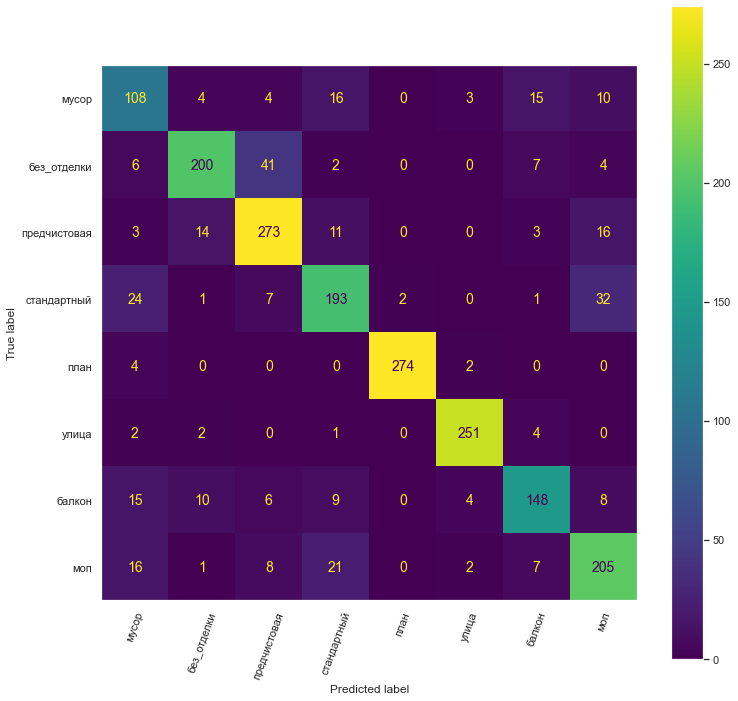

In [54]:
#ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = classes)

fig, ax = plt.subplots(figsize = (12, 12))
#ax.grid(False)
disp.plot(values_format = '.3g', ax = ax)
plt.xticks(rotation = 70)
plt.grid(False)
plt.show();

In [11]:
model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

model = xgb.Booster()
model.load_model('xgboost_rn152v2_md5_gap_1.model')

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

img_trash_all = []
img_wf_all = []
img_prefin_all = []
img_stand_all = []
img_plan_all = []
img_street_all = []
img_balc_all = []
img_mop_all = []

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    for img_name in tqdm(img_names, 'Обработано', position = 0):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        x = np.expand_dims(x, axis = 0)
        x = pi_rnv2(x) #/ 255
        
        pr_rn152v2 = model_rn152v2.predict(x, verbose = None)       #делаем предсказание
        avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D() #уменьшает размерность глобально
        feature = avg_pool(pr_rn152v2).numpy()
        
        preds = model.predict(xgb.DMatrix(pd.DataFrame(feature)))
        pr = {'Predict': int(preds[0]), 'Class_name': classes[i], 'True': i, 'Foto_name': img_name}
        
        if i == 0:
            img_trash_all.append(pr)
        elif i == 1:
            img_wf_all.append(pr)
        elif i == 2:
            img_prefin_all.append(pr)
        elif i == 3:
            img_stand_all.append(pr)
        elif i == 4:
            img_plan_all.append(pr)
        elif i == 5:
            img_street_all.append(pr)
        elif i == 6:
            img_balc_all.append(pr)
        else:
            img_mop_all.append(pr)


df_trash = pd.DataFrame(img_trash_all)
df_wf = pd.DataFrame(img_wf_all)
df_prefin = pd.DataFrame(img_prefin_all)
df_stand = pd.DataFrame(img_stand_all)
df_plan = pd.DataFrame(img_plan_all)
df_street = pd.DataFrame(img_street_all)
df_balc = pd.DataFrame(img_balc_all)
df_mop = pd.DataFrame(img_mop_all)

df_all = pd.concat([df_trash, df_wf, df_prefin, df_stand, df_plan, df_street, df_balc, df_mop])
CM = confusion_matrix(df_all['True'], df_all['Predict'])
print(CM)

Обработано: 0it [00:00, ?it/s]

Обработано:   0%|          | 0/553 [00:00<?, ?it/s]

Обработано:   0%|          | 0/3689 [00:00<?, ?it/s]

Обработано:   0%|          | 0/4619 [00:00<?, ?it/s]

Обработано:   0%|          | 0/3947 [00:00<?, ?it/s]

Обработано:   0%|          | 0/4250 [00:00<?, ?it/s]

Обработано:   0%|          | 0/7564 [00:00<?, ?it/s]

Обработано:   0%|          | 0/1166 [00:00<?, ?it/s]

Обработано:   0%|          | 0/2742 [00:00<?, ?it/s]

[[ 332   21   18   59    4   32   41   46]
 [  80 2792  578   54    2   14   98   71]
 [ 178  276 3703  235    0    0   49  178]
 [ 368   39   79 3031    1    8   65  356]
 [  29    0    0    3 4194   20    0    4]
 [  97   35    1   12    4 7159  163   93]
 [  80   73   17   44    0   27  871   54]
 [ 162   60  132  317    0   27   92 1952]]


In [12]:
from sklearn.metrics import accuracy_score

print(accuracy_score(df_all['Predict'], df_all['True']))

0.8424114966701718


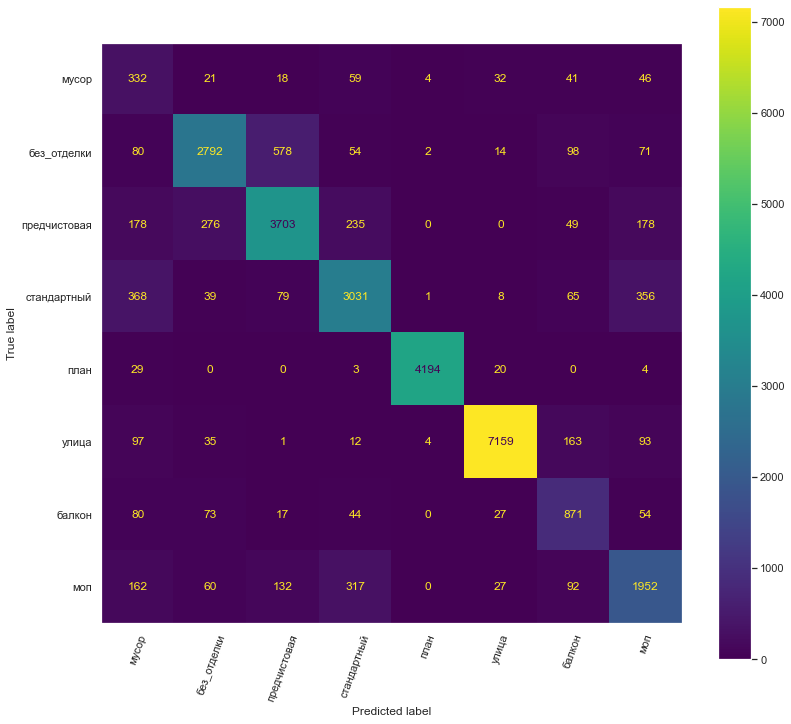

In [13]:
#ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = classes)

fig, ax = plt.subplots(figsize = (13, 12))
disp.plot(values_format = '.6g', ax = ax)
plt.xticks(rotation = 70)
plt.grid(False)
plt.show();

In [14]:
#classification_report
print("\nClassification Report : ")
print(classification_report(df_all['True'], df_all['Predict'], target_names = classes))


Classification Report : 
              precision    recall  f1-score   support

       мусор       0.25      0.60      0.35       553
 без_отделки       0.85      0.76      0.80      3689
предчистовая       0.82      0.80      0.81      4619
 стандартный       0.81      0.77      0.79      3947
        план       1.00      0.99      0.99      4250
       улица       0.98      0.95      0.96      7564
      балкон       0.63      0.75      0.68      1166
         моп       0.71      0.71      0.71      2742

    accuracy                           0.84     28530
   macro avg       0.76      0.79      0.76     28530
weighted avg       0.86      0.84      0.85     28530



In [15]:
#Сохраняем в Excel
writer = pd.ExcelWriter('Классификация_фото.xlsx')
df_all.to_excel(writer, 'прогноз')
writer.save()